In [ ]:
# import libraries 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils")

from construct_model import *
from text_pre_processor import *

%aimport construct_model
%aimport text_pre_processor

In [3]:
posts_df = pd.read_pickle('../data/interum/text_target.pkl')

In [4]:
# convert into features and target 
feature = posts_df['cleaned_text']
label = posts_df['target']

## we will focus on:

* MultinomialNB
* RandomForest
* LogisticRegression

## Logistic regression 

In [5]:
# after paramater tuning logistic regression works best with slight tuning for tfidvector
tfidf_vect_lg = TfidfVectorizer(ngram_range=(1,2),max_df=0.5,min_df=6, max_features=9000)
# hyperparamater from extensive model gridsearch/randomsearch
lg = LogisticRegression(C=2, penalty='l1',random_state=42)

In [6]:
# run model and get results for logistic regression 
lg_model = ConstructModel([tfidf_vect_lg, lg],feature,label)

In [8]:
# check model accuracy score for test and train 
lg_model.get_score()

Train Score:	 0.8931149705045172
Test Score:	 0.8150470219435737


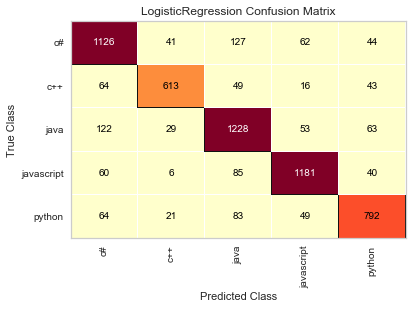

In [10]:
# check confusion matrix
lg_model.get_confusion_matrix()

## RandomForest 

## multinominalNB 

In [ ]:
# Create regularization hyperparameter distribution using uniform distribution
alpha =uniform(loc=0, scale=5)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',nb),
])
max_df = np.linspace(0.3,0.75,num = 10)
min_df = np.arange(1,16,2)
max_features = np.arange(5000,10000,500)
parameters = {
        'vect__ngram_range':((1,1),(1,2)),
        'vect__max_df': max_df,
        'vect__min_df':min_df,
        'vect__max_features':max_features,
        'clf': (nb,),
        'clf__alpha':alpha
            }
clf_nb = RandomizedSearchCV(pipeline, parameters,random_state = 42, n_iter=100, cv = 3, n_jobs=14)

In [ ]:
clf_nb.fit(train_X,train_y)

In [ ]:
coefs = clf_nb.best_estimator_['clf'].feature_log_prob_

In [ ]:
featurenames = clf_nb.best_estimator_['vect'].get_feature_names()

In [ ]:
classes = clf_nb.classes_

In [ ]:
coef_dict_nb={}
for i, cls in enumerate(classes):
    coef_dict_nb[cls]=[]
    for c, f in zip(coefs[i],featurenames):
        if c:
            coef_dict_nb[cls].append((f,c))

In [ ]:
sorted(coef_dict_nb['python'], key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(coef_dict_nb['c#'], key = lambda x: x[1])[:10]

In [ ]:
clf_nb.best_params_

In [ ]:
clf_nb.score(train_X,train_y)

In [ ]:
clf_nb.score(test_X,test_y)

In [ ]:
# finer search
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',nb),
])
parameters = {
        'vect__ngram_range':((1,2),),
        'vect__max_df': (0.45,0.55),
        'vect__min_df':(4,6),
        'vect__max_features':(7000,8000),
        'clf': (nb,),
        'clf__alpha': (0.2,0.3)}
grid_search_nb = GridSearchCV(pipeline, parameters, cv = 3, return_train_score= True,n_jobs=14)

In [ ]:
grid_search_nb.fit(train_X,train_y)

In [ ]:
grid_search_nb.best_estimator_

In [ ]:
grid_search_nb.score(train_X,train_y)

In [ ]:
grid_search_nb.score(test_X,test_y)

In [ ]:
coefs_nb = grid_search_nb.best_estimator_['clf'].feature_log_prob_

In [ ]:
featurenames_nb = grid_search_nb.best_estimator_['vect'].get_feature_names()

In [ ]:
classes = grid_search_nb.classes_

In [ ]:
coef_dict_nb={}
for i, cls in enumerate(classes):
    coef_dict_nb[cls]=[]
    for c, f in zip(coefs_nb[i],featurenames_nb):
        if c:
            coef_dict_nb[cls].append((f,c))

In [ ]:
sorted(coef_dict_nb['javascript'], key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(coef_dict_nb['javascript'], key = lambda x: x[1])[:10]

### combine results and do a majority vote 

In [ ]:
pred_lg = grid_search_lg.predict(test_X)
pred_rf = grid_search_rf.predict(test_X)
pred_nb = grid_search_nb.predict(test_X)

In [ ]:
votes = Counter([pred_lg[122],pred_rf[122], pred_nb[122]])

In [ ]:
for i,v in votes.items():
    if votes[i]==max(votes.values()):
        print(i)

In [ ]:
import numpy as np

In [ ]:
np.random.random

In [ ]:
combined = []
predicted = zip(pred_lg,pred_rf,pred_nb)
for p in predicted:
    votes = Counter(p)
    most = max(votes.values())
    if most >1:
        combined.append(list(votes.keys())[list(votes.values()).index(most)])
    else:
        combined.append(np.random.choice(list(votes.keys()),1)[0])
    
    

In [ ]:
accuracy_score(test_y,combined)

In [ ]:
confusion_matrix(test_y, combined)

In [ ]:
classes

In [ ]:
grid_search_lg.best_estimator_

In [ ]:
with open('gs_lg','wb') as f:
    pickle.dump(grid_search_lg,f)

In [ ]:
with open('gs_lg','rb') as f:
    t_lg = pickle.load(f)

In [ ]:
t_lg.predict(test_X)

In [ ]:
with open('gs_rf','wb') as f:
    pickle.dump(grid_search_rf, f)

In [ ]:
with open('gs_rf','rb') as f:
    t_rf = pickle.load(f)

In [ ]:
t_rf.predict(test_X)

In [ ]:
with open('gs_nb','wb') as f:
    pickle.dump(grid_search_nb,f)

In [ ]:
with open('gs_nb','rb') as f:
    t_nb = pickle.load(f)

In [ ]:
t_nb.predict(test_X)

In [ ]:
from sklearn.decomposition import PCA
kmeans = KMeans(n_clusters=5).fit(x_train_tfidf)

In [ ]:
kmeans = KMeans(n_clusters=5)

In [ ]:
kmeans.fit(x_train_tfidf)

In [ ]:
def coef_features(modelname, lg = True):
    labels = modelname.classes_  # label 
    if lg:
        coefs = modelname.best_estimator_['clf'].coef_
    else:
        coefs = modelname.best_estimator_['clf'].feature_log_prob_
    featurenames = modelname.best_estimator_['vect'].get_feature_names()
    coef_dict={}
    for i, l in enumerate(labels):
        coef_dict[l]=[]
        for c, f in zip(coefs[i],featurenames):
            if c:
                coef_dict[l].append((f,c))
    return coef_dict   

import pickle
with open('gs_nb','rb') as f:
    t_nb = pickle.load(f)
with open('gs_lg','rb') as f:
    t_lg = pickle.load(f)

lg_coef_f = coef_features(t_lg)
nb_coef_f = coef_features(t_nb)

def top_10_feature(coef_dict):
    top_10 = {}
    for l in coef_dict.keys():
        top_10[l] = sorted(coef_dict[l], key = lambda x: x[1], reverse = True)[:10]
        top_10[l] = [x[0] for x in top_10[l]]
    return pd.DataFrame(top_10)

pd.concat([top_10_feature(lg_coef_f),top_10_feature(nb_coef_f)], axis = 1)

    